### This notebooks adds various attributes to the BDP master sample vector data

The attributes and source used added are:
* NLCD 2011 landcover %Open Water, %NoData
* Nation Map govenment units (GU) % US State and County
* PADUS %Land Ownership top 10 categories

Created by Colin Talbert 6/1/2017

#### Import the libraries we'll be using

In [1]:
import os
import csv
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import rasterio
import fiona
from shapely.geometry import shape
import shapely
from osgeo import gdal

import geopandas as gpd

#### Set the paths to the input data we'll be using.  These are intermediate data that have been projected to match the master sample input layer

In [2]:
master_sample_10k_fname = r"N:\GISData\active\Brown_GIS_WebApps\bpd\grts\master_sample\complete_conus_mastersample_10km.shp"

projected_dname = r"N:\GISData\Active\Brown_GIS_WebApps\bpd\grts\DerivedData\talbert_processing\FinalProjectedLayers"
#2011 National Landcover data downloaded from the National Map May 30, 2017
#The original source downloaded for this project can be found at: 
#    N:\Active\Brown_GIS_WebApps\bpd\grts\SourceData\National_map_20170523\nlcd_2011_landcover_2011_edition_2014_10_10
#This was projected to Nad83 albers in ESRI
nlcd_fname = os.path.join(projected_dname, "nlcd_2011_landcover_83Albers.tif")

#State and county geometries download from the National Map May 23, 2017
#The original source downloaded for this project can be found at: 
#    N:\Active\Brown_GIS_WebApps\bpd\grts\SourceData\National_map_20170523\National_GovernmentUnits
#This was projected to Nad83 albers in ESRI
projected_dname = r"N:\GISData\Active\Brown_GIS_WebApps\bpd\grts\DerivedData\talbert_processing\FinalProjectedLayers"
states_fname = os.path.join(projected_dname, "GU_StateOrTerritory_Project.shp")
counties_fname = os.path.join(projected_dname, "GU_CountyOrEquivalent_Project.shp")

#PADUS 1.4 Land ownership downloaded from https://gapanalysis.usgs.gov/padus/data/download/ Map May 25, 2017
#The original source downloaded for this project can be found at: 
#    N:\Active\Brown_GIS_WebApps\bpd\grts\SourceData\National_map_20170523\PADUS1_4Shapefile
#This data was projected to Nad83 albers in ESRI
#This data was converted to raster with dimensions and cell size set to match nlcd (30m cells)
ownership_fname = os.path.join(projected_dname, "nlcd_PADUS1_4_LOwnMang.tif")
#this csv is an export of the ownership value attribute table, that we'll use to lookup ownership names
ownership_lookup_fname = os.path.join(projected_dname, "LOwnMang_lookup.csv")


#### Load our input datasets (but not necissarily read into memory, too big) 

In [ ]:
fname = r"C:\Users\talbertc\Downloads\CONUS10kmx10kmg\All_grts_CONUS_wtop5perc\All_grts_CONUS_wtop5perc.shp"


In [3]:
master_sample = fiona.open(master_sample_10k_fname)

nlcd = rasterio.open(nlcd_fname)
states = fiona.open(states_fname)
counties = fiona.open(counties_fname)
ownership = rasterio.open(ownership_fname)

#### Write some helper functions to conveniently pull data for a given sample unit

In [4]:
def get_grts_id(grts_id):
    return list(filter(lambda f: f['properties']['GRTS_ID']==grts_id, master_sample))[0]

#this grid cell spans the Columbia river
test_grid_cell = get_grts_id(2)

### NLCD helper functions

In [10]:
print(master_sample['properties'])

None


(-0.5, 332.5, 333.5, -0.5)

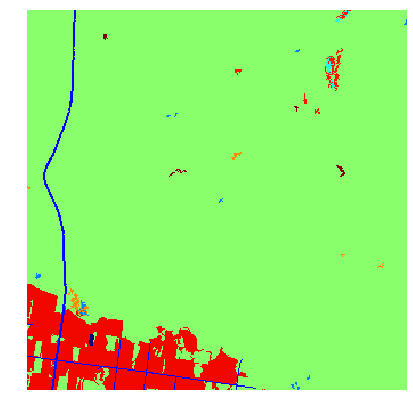

In [7]:
%matplotlib inline
def get_nlcd_data(s):
    bounds = shape(s['geometry']).bounds
    ul = bounds[0], bounds[3]
    lr = bounds[2], bounds[1]

    ul_index = nlcd.index(*ul)
    lr_index = nlcd.index(*lr)

    d = nlcd.read(window=tuple(zip(ul_index, lr_index)))
    return d

data = get_nlcd_data(test_grid_cell)

plt.figure(figsize=(7, 7))
sns.set_style("dark")
sns.despine()
plt.imshow(data[0, :, :], cmap=mpl.cm.jet, interpolation=None)
plt.axis('off')

In [6]:
def percent_water(data):
    return np.sum(data==11)/(data.shape[1] * data.shape[2])*100

def percent_outside(data):
    return np.sum(data==0)/(data.shape[1] * data.shape[2])*100

### State and County helper functions

In [7]:
states_geo = {state['properties']['STATE_NAME']: shape(state['geometry']) for state in list(states)}

In [8]:
counties_geo = {}
for county in counties:
    name = "_".join([county['properties']['STATE_NAME'], county['properties']['COUNTY_NAM']])
    geo = shape(county['geometry'])
    counties_geo[name] = geo


In [9]:
def state_intersects(shape):
    intersections = []
    shape_area = shape.area
    for state_name, state_geo in states_geo.items():
        if state_geo.intersects(shape):
            intersections.append((state_name, shape.intersection(state_geo).area/shape_area))
    return sorted(intersections, key=lambda tup: tup[1], reverse=True)
        
state_intersects(shape(test_grid_cell['geometry']))

[('Colorado', 1.0)]

In [10]:
def county_intersects(shape):
    intersections = []
    shape_area = shape.area
    for county_name, county_geo in counties_geo.items():
        if county_geo.intersects(shape):
            intersections.append((county_name, shape.intersection(county_geo).area/shape_area))
    return sorted(intersections, key=lambda tup: tup[1], reverse=True)
        
county_intersects(shape(test_grid_cell['geometry']))

[('Colorado_Mesa', 1.0)]

### Ownership helper functions

In [11]:
import csv
reader = csv.reader(open(ownership_lookup_fname))
next(reader, None)

ownership_lookup = {}
for row in reader:
    key = row[1]
    ownership_lookup[int(key)] = row[3]
    
ownership_lookup[30] = 'NODATA'

In [12]:
ownership_lookup

{1: 'FWS',
 2: 'NPS',
 3: 'STATE',
 4: 'NOAA',
 5: 'JNT',
 6: 'UNK',
 7: 'USBR',
 8: 'BLM',
 9: 'TRIB',
 10: 'USFS',
 11: 'USACE',
 12: 'NGO',
 13: 'CNTY',
 14: 'UNKL',
 15: 'REG',
 16: 'RWD',
 17: 'CITY',
 18: 'PVT',
 19: 'DOD',
 20: 'OTHF',
 21: 'TVA',
 30: 'NODATA'}

(-0.5, 332.5, 333.5, -0.5)

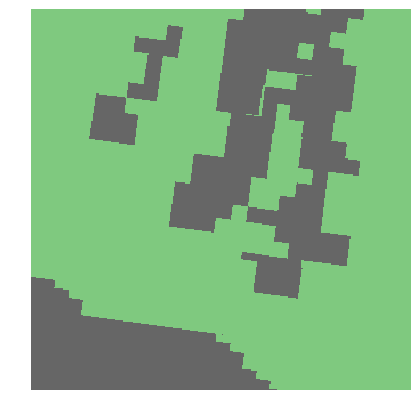

In [13]:
def get_ownership_data(s):
    bounds = s.bounds
    ul = bounds[0], bounds[3]
    lr = bounds[2], bounds[1]

    ul_index = ownership.index(*ul)
    lr_index = ownership.index(*lr)

    d = ownership.read(window=tuple(zip(ul_index, lr_index)))
    d[d==255] = 30  #convert nodata from 255 to 30
    
    #reclass to lump minor categories
    d[d==21] = 15 # TVA with REG
    d[d==16] = 15 # RWD with REG
    d[d==14] = 6 # UNKL with UNK
    return d

test_shape = shape(test_grid_cell['geometry'])
data = get_ownership_data(test_shape)

plt.figure(figsize=(7, 7))
plt.imshow(data[0, :, :], cmap=plt.cm.Accent)
plt.axis('off')

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

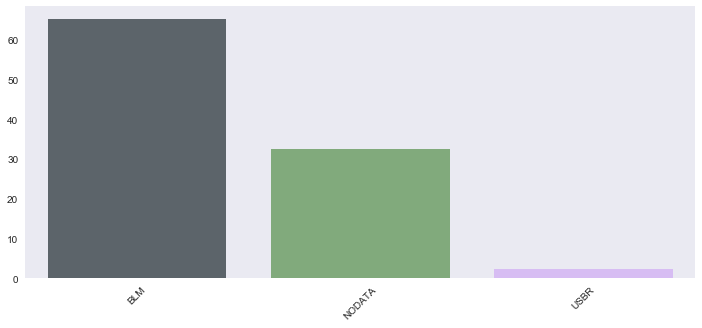

In [14]:
def get_ownership_stats(s):
    data = get_ownership_data(s)
    hist_data = np.unique(data, return_counts=True)
    merged = list(zip([ownership_lookup[i] for i in hist_data[0]],
            [i/np.sum(hist_data[1])*100 for i in hist_data[1]]))
    return sorted(merged, key=lambda tup: tup[1], reverse=True)

stats = get_ownership_stats(test_shape)
d = list(zip(*stats))

plt.figure(figsize=(12, 5))
colors = ['slate grey', 'faded green', 'light violet', 'windows blue']
g = sns.barplot(d[0], d[1], palette=sns.xkcd_palette(colors))
plt.xticks(rotation=45)

### Output helper functions

In [15]:
owner_labels = ['own_' + o for o in ownership_lookup.values() if o not in ['RWD', 'TVA', 'UNKL']]
owner_labels.sort()
owner_labels

['own_BLM',
 'own_CITY',
 'own_CNTY',
 'own_DOD',
 'own_FWS',
 'own_JNT',
 'own_NGO',
 'own_NOAA',
 'own_NODATA',
 'own_NPS',
 'own_OTHF',
 'own_PVT',
 'own_REG',
 'own_STATE',
 'own_TRIB',
 'own_UNK',
 'own_USACE',
 'own_USBR',
 'own_USFS']

In [16]:
col_names = ['GRTS_ID', 'water_p', 'outside_p', 
                        'state_n_1', 'state_p_1', 
                        'state_n_2', 'state_p_2',
                        'state_n_3', 'state_p_3',
                        'state_n_4', 'state_p_4',
                        'cnty_n_1', 'cnty_p_1', 
                        'cnty_n_2', 'cnty_p_2',
                        'cnty_n_3', 'cnty_p_3',
                        'cnty_n_4', 'cnty_p_4',
                        'cnty_n_5', 'cnty_p_5',
 ]

col_names += owner_labels

final_df = pd.DataFrame([["NA"]*len(col_names)], columns=col_names)
final_df

,GRTS_ID,water_p,outside_p,state_n_1,state_p_1,state_n_2,state_p_2,state_n_3,state_p_3,state_n_4,...,own_NPS,own_OTHF,own_PVT,own_REG,own_STATE,own_TRIB,own_UNK,own_USACE,own_USBR,own_USFS
0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [17]:
import collections
def empty_row():
    d = collections.OrderedDict()
    for col_name in col_names:
        if col_name.startswith('own_'):
            d[col_name] = '0'
        else:
            d[col_name] = 'NA'
    return d

# Finally!  Run through all of them and produce our output csv

In [18]:
i = 0
output_fname = r"N:\Active\Brown_GIS_WebApps\bpd\grts\DerivedData\talbert_processing\output_10k.csv"

for grid_cell in master_sample:
#     print(grid_cell['properties']['GRTS_ID'])
    this_row = empty_row()
    this_row['GRTS_ID'] = grid_cell['properties']['GRTS_ID']
    nlcd_data = get_nlcd_data(grid_cell)
    this_row['water_p'] = percent_water(nlcd_data)
    this_row['outside_p'] = percent_outside(nlcd_data)
    
    
    state_i = state_intersects(shape(grid_cell['geometry']))
    county_i = county_intersects(shape(grid_cell['geometry']))
    
    for state_num, (state_name, pcnt) in enumerate(state_i):
        this_row['state_n_{}'.format(state_num+1)] = state_name
        this_row['state_p_{}'.format(state_num+1)] = pcnt*100
        
    for county_num, (county_name, pcnt) in enumerate(county_i):
        this_row['cnty_n_{}'.format(county_num+1)] = county_name
        this_row['cnty_p_{}'.format(county_num+1)] = pcnt*100
    
    ownership_i = get_ownership_stats(shape(grid_cell['geometry']))
    for owner_num, (owner_name, pcnt) in enumerate(ownership_i):
        this_row['own_' + owner_name] = pcnt
    
    
    this_row_df = pd.DataFrame(this_row, index=[i])
    final_df = final_df.append(this_row_df)
    
    i +=1
    if np.mod(i, 1000) == 0:
        print(i, sep=' ')
        final_df.to_csv(output_fname, index=False)
#         break
        
final_df = final_df[col_names]

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000


### Join the resulting DF back onto our shapefile and save back out to disk

In [ ]:
master = gpd.read_file(master_sample_10k_fname)
merged = master.merge(final_df, on='GRTS_ID')

for col_name in merged.columns:
    if col_name.startswith('own_') or '_p_' in col_name:
        this_col = pd.to_numeric(merged[col_name], errors='coerce').fillna(0)
        merged[col_name] = this_col

final_out_fname =  r"N:\active\Brown_GIS_WebApps\bpd\grts\master_sample\complete_conus_mastersample_10km_attributed3.shp"
merged.to_file(final_out_fname)